# OpenTab Experiments

Interactive exploration of synthetic data priors, model architecture, training, and evaluation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.datasets import make_classification, load_iris, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import our modules
from model import OpenTabModel, OpenTabClassifier
from generate_data import MLPPrior, GPPrior, TreePrior, SCMPrior, MixedPrior

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


## 1. Visualizing Synthetic Data Priors

TabPFN is trained on synthetic data generated by various "priors".
Each prior creates datasets with different characteristics.

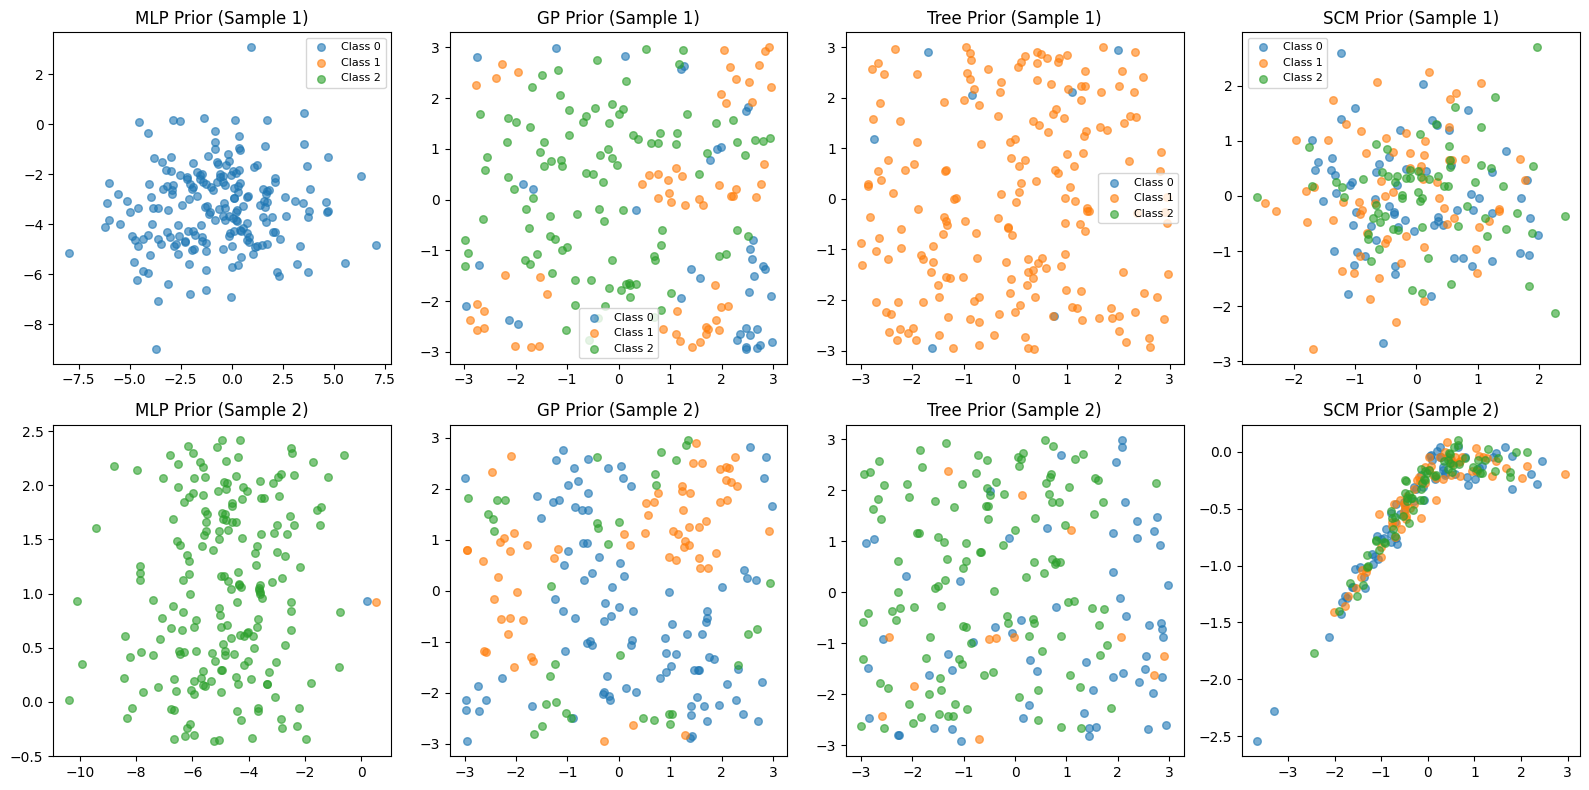

In [10]:
# Create priors
priors = {
    'MLP': MLPPrior(),
    'GP': GPPrior(),
    'Tree': TreePrior(),
    'SCM': SCMPrior(),
}

# Visualize samples from each prior
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for col, (name, prior) in enumerate(priors.items()):
    for row in range(2):
        ax = axes[row, col]
        
        # Generate 2D dataset for visualization
        dataset = prior.generate(n_samples=200, n_features=2, n_classes=3)
        
        for c in range(3):
            mask = dataset.y == c
            ax.scatter(dataset.X[mask, 0], dataset.X[mask, 1], 
                      alpha=0.6, label=f'Class {c}', s=30)
        
        ax.set_title(f'{name} Prior (Sample {row+1})')
        if row == 0:
            ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### Understanding Prior Differences

- **MLP Prior**: Creates smooth, curved decision boundaries from random neural networks
- **GP Prior**: Creates smooth, blob-like regions from Gaussian Processes
- **Tree Prior**: Creates axis-aligned, rectangular regions from decision trees
- **SCM Prior**: Creates patterns based on causal relationships (DAGs)

## 2. Model Architecture

In [ ]:
# Create a small model
model = OpenTabModel(
    embedding_size=64,
    n_heads=4,
    mlp_hidden_size=128,
    n_layers=2,
    n_outputs=5,
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Show model structure
print("\nModel structure:")
print(model)

In [ ]:
# Test forward pass
batch_size = 4
n_samples = 20
n_features = 5
train_size = 15  # int, not tensor
n_test = n_samples - train_size

X = torch.randn(batch_size, n_samples, n_features)
y_train = torch.randint(0, 5, (batch_size, train_size))  # Only train labels!

# Forward pass - note we pass y_train (not full y) and train_size as int
logits = model(X, y_train, train_size)
print(f"Input X shape: {X.shape}")
print(f"Input y_train shape: {y_train.shape}")
print(f"Output logits shape: {logits.shape}")
print(f"Expected: (batch={batch_size}, n_test={n_test}, n_outputs=5)")

# Show predictions
probs = F.softmax(logits, dim=-1)
print(f"\nPrediction probabilities for first test sample:")
print(f"  Probabilities: {probs[0, 0].detach().numpy().round(3)}")

## 3. Training on Synthetic Data

In [ ]:
# Create a training function for the notebook
def train_mini_tabpfn(
    n_steps=500,
    batch_size=16,
    lr=1e-3,
    embedding_size=64,
    n_layers=2,
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create model with correct parameter names
    model = OpenTabModel(
        embedding_size=embedding_size,
        n_heads=4,
        mlp_hidden_size=embedding_size * 2,
        n_layers=n_layers,
        n_outputs=10,  # Support up to 10 classes
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    prior = MixedPrior()
    
    losses = []
    
    for step in range(n_steps):
        # Generate batch of datasets
        batch_X = []
        batch_y = []
        batch_train_size = []
        batch_n_samples = []
        
        max_samples = 50
        max_features = 10
        
        for _ in range(batch_size):
            n_samples = np.random.randint(10, max_samples)
            n_features = np.random.randint(2, max_features)
            n_classes = np.random.randint(2, 5)
            
            dataset = prior.generate(n_samples, n_features, n_classes)
            
            # Pad
            X_padded = np.zeros((max_samples, max_features))
            X_padded[:n_samples, :n_features] = dataset.X
            
            y_padded = np.zeros(max_samples, dtype=np.int64)
            y_padded[:n_samples] = dataset.y
            
            batch_X.append(X_padded)
            batch_y.append(y_padded)
            batch_train_size.append(dataset.train_size)
            batch_n_samples.append(n_samples)
        
        X = torch.tensor(np.array(batch_X), dtype=torch.float32).to(device)
        y = torch.tensor(np.array(batch_y), dtype=torch.long).to(device)
        
        # Process each sample individually since train_size varies
        loss_sum = 0
        count = 0
        for i in range(batch_size):
            ts = batch_train_size[i]
            ns = batch_n_samples[i]
            
            if ts < ns:
                # Extract single sample and only train labels
                X_i = X[i:i+1]  # (1, max_samples, max_features)
                y_train_i = y[i:i+1, :ts]  # (1, train_size) - only train labels!
                
                # Forward pass
                logits = model(X_i, y_train_i, ts)  # (1, n_test, n_outputs)
                
                # Get test predictions (model outputs for test positions)
                n_test = ns - ts
                test_logits = logits[0, :n_test]  # (n_test, n_outputs)
                test_targets = y[i, ts:ns]  # (n_test,)
                
                if len(test_logits) > 0:
                    loss_sum += F.cross_entropy(test_logits, test_targets)
                    count += 1
        
        loss = loss_sum / max(count, 1)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        losses.append(loss.item())
        
        if (step + 1) % 100 == 0:
            avg_loss = np.mean(losses[-100:])
            print(f"Step {step+1}/{n_steps} | Loss: {avg_loss:.4f}")
    
    return model, losses

In [ ]:
# Train for a few steps (quick demo)
model, losses = train_mini_tabpfn(n_steps=300, batch_size=16)

# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.3, label='Raw')
# Smoothed
window = 20
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(losses)), smoothed, label='Smoothed')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Evaluation on Real Datasets

In [ ]:
# Reload the model module to pick up the fix
import importlib
import model
importlib.reload(model)
from model import OpenTabClassifier

# Load the best model from checkpoint
classifier = OpenTabClassifier("checkpoints/minitabpfn.pt/best_model.pt")

# Test on Iris dataset
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit and predict
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
y_proba = classifier.predict_proba(X_test_scaled)

accuracy = (y_pred == y_test).mean()
print(f"Iris Dataset Accuracy: {accuracy:.4f}")
print(f"\nSample predictions:")
for i in range(5):
    print(f"  True: {y_test[i]}, Pred: {y_pred[i]}, Probs: {y_proba[i].round(3)}")

Iris Dataset Accuracy: 0.5111

Sample predictions:
  True: 1, Pred: 0, Probs: [0.45  0.384 0.166]
  True: 0, Pred: 0, Probs: [0.599 0.27  0.13 ]
  True: 2, Pred: 0, Probs: [0.489 0.371 0.14 ]
  True: 1, Pred: 0, Probs: [0.432 0.4   0.168]
  True: 1, Pred: 0, Probs: [0.456 0.384 0.159]


In [ ]:
# Test on Wine dataset
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=42
)

# Scale and predict
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)

accuracy = (y_pred == y_test).mean()
print(f"Wine Dataset Accuracy: {accuracy:.4f}")

In [ ]:
# Test on synthetic classification
X, y = make_classification(
    n_samples=200,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_classes=3,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)

accuracy = (y_pred == y_test).mean()
print(f"Synthetic Classification Accuracy: {accuracy:.4f}")

## 5. In-Context Learning

Visualizing how OpenTab processes training data as context for predictions.

In [ ]:
# Create a simple 2D classification problem
np.random.seed(42)

# Training data: two clusters
X_train_2d = np.vstack([
    np.random.randn(20, 2) + [2, 0],  # Class 0
    np.random.randn(20, 2) + [-2, 0], # Class 1
])
y_train_2d = np.array([0]*20 + [1]*20)

# Shuffle
perm = np.random.permutation(len(X_train_2d))
X_train_2d = X_train_2d[perm]
y_train_2d = y_train_2d[perm]

# Fit
classifier.fit(X_train_2d, y_train_2d)

# Create grid for decision boundary
xx, yy = np.meshgrid(
    np.linspace(-5, 5, 100),
    np.linspace(-4, 4, 80)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict on grid
proba = classifier.predict_proba(grid)
zz = proba[:, 1].reshape(xx.shape)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Decision boundary
contour = ax.contourf(xx, yy, zz, levels=20, cmap='RdBu', alpha=0.6)
ax.contour(xx, yy, zz, levels=[0.5], colors='black', linewidths=2)

# Training points
for c, color, marker in [(0, 'red', 'o'), (1, 'blue', 's')]:
    mask = y_train_2d == c
    ax.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], 
              c=color, marker=marker, s=100, edgecolor='black',
              label=f'Class {c} (train)')

plt.colorbar(contour, label='P(class=1)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('OpenTab Decision Boundary (In-Context Learning)')
ax.legend()
plt.show()

## 6. Performance vs Training Set Size

Comparing OpenTab to Random Forest on small datasets.

In [ ]:
# Test with different training set sizes
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()
X, y = iris.data, iris.target

train_sizes = [5, 10, 20, 30, 50, 70]
n_trials = 5

results = {'TabPFN': [], 'RandomForest': []}

for n_train in train_sizes:
    tabpfn_scores = []
    rf_scores = []
    
    for trial in range(n_trials):
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=n_train, random_state=trial
        )
        
        # Scale
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        # TabPFN
        classifier.fit(X_train_s, y_train)
        tabpfn_acc = (classifier.predict(X_test_s) == y_test).mean()
        tabpfn_scores.append(tabpfn_acc)
        
        # Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=trial)
        rf.fit(X_train_s, y_train)
        rf_acc = (rf.predict(X_test_s) == y_test).mean()
        rf_scores.append(rf_acc)
    
    results['TabPFN'].append((np.mean(tabpfn_scores), np.std(tabpfn_scores)))
    results['RandomForest'].append((np.mean(rf_scores), np.std(rf_scores)))

# Plot
plt.figure(figsize=(10, 5))

for name, color in [('TabPFN', 'blue'), ('RandomForest', 'orange')]:
    means = [r[0] for r in results[name]]
    stds = [r[1] for r in results[name]]
    
    plt.plot(train_sizes, means, 'o-', label=name, color=color)
    plt.fill_between(train_sizes, 
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.2, color=color)

plt.xlabel('Training Set Size')
plt.ylabel('Test Accuracy')
plt.title('Performance vs Training Set Size (Iris Dataset)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

This notebook covered:

1. **Priors** - Synthetic data generation (MLP, GP, Tree, SCM)
2. **Architecture** - Transformer with dual attention  
3. **Training** - Training loop on synthetic data
4. **Evaluation** - Testing on Iris, Wine, and synthetic datasets
5. **In-Context Learning** - Decision boundary visualization
6. **Small Data** - Performance vs training set size

**Next Steps:**
```bash
uv run python train.py --steps 10000       # Full training
uv run python evaluate.py                   # TabArena benchmark
```